# User intent recognition model
Source: https://github.com/AldoF95/intent_recognition_masters_thesis

`!pip install tensorflow_text` requires runtime restart

CPU Training time
- ~~Execution time: ~4m (training included)~~
- ~~Training time: 2m (2 epochs)~~

GPU Training time
- ~~Execution time: ~2m (training included)>~~
- ~~Training time: 40s (2 epochs)~~



In [240]:
# Define training epochs
training_epochs = 10

# Define dataset URL for training (old published excel file)
UIDatasetURL_ = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRKZziYPXXp-C3-GWkzAdPaWBRgRidy5OYMwt8RCDEzFLczk4MG8hi3e2Glc7EfEw/pub?output=xlsx'

# Define dataset URL for training (new published excel file)
UIDatasetURL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSPR-FPTMBcYRynP4JdwYQQ8dAhSx1x8i1LPckUcuIUUlrWT82b5Thqb1bBNnPeGJPxxX1CJAlFSd6F/pub?output=xlsx'

In [241]:
# Will require runetime restart on Google colab
!pip install tensorflow_text

In [ ]:
!pip install text-hr

## Data loading

- Define the preprocesor and the base model
- LaBSE 2 base model used: https://tfhub.dev/google/LaBSE/2
- Load the data from published google spreadsheet
- Merge categories and Normalize data within them

In [243]:
import tensorflow as tf
import tensorflow_text as tft
import tensorflow_hub as tfh
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [244]:
# Text preprocessor for bert based models
preprocessor = tfh.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2')

# Language Agnostic BERT sentence encoder
model = tfh.KerasLayer('https://tfhub.dev/google/LaBSE/2')

In [245]:
# Read the data
data = pd.read_excel(UIDatasetURL)

In [246]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      13 non-null     object
 1   Question  13 non-null     object
dtypes: object(2)
memory usage: 336.0+ bytes


In [247]:
columns = ['text', 'intent']
data.columns = columns

### Category merging

In [248]:
# Convert categories to codes
data['intent'] = data['intent'].astype('category')
data['intent_codes'] = data['intent'].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

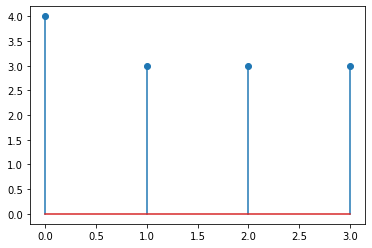

In [249]:
# Display the distribution of codes
values = data['intent'].value_counts()
plt.stem(values)

### Normalize data

In [250]:
"""
upis_data = data[data['intent02'] == 'upis_na_sveuciliste']
upis_data = upis_data.sample(frac=1, random_state=1234)
upis_data = upis_data.sample(40)
upis_data.info()
"""

"\nupis_data = data[data['intent02'] == 'upis_na_sveuciliste']\nupis_data = upis_data.sample(frac=1, random_state=1234)\nupis_data = upis_data.sample(40)\nupis_data.info()\n"

In [251]:
"""
ood_data = data[data['intent02'] == 'OOD']
ood_data = ood_data.sample(frac=1, random_state=1234)
ood_data = ood_data.sample(40)
ood_data.info()
"""

"\nood_data = data[data['intent02'] == 'OOD']\nood_data = ood_data.sample(frac=1, random_state=1234)\nood_data = ood_data.sample(40)\nood_data.info()\n"

In [252]:
"""
data2 = data[(data['intent02'] != 'OOD') & (data['intent02'] != 'upis_na_sveuciliste')]
data2.info()
"""

"\ndata2 = data[(data['intent02'] != 'OOD') & (data['intent02'] != 'upis_na_sveuciliste')]\ndata2.info()\n"

In [253]:
"""
data2 = data2.append(upis_data, ignore_index=True)
data2 = data2.append(ood_data, ignore_index=True)
"""

'\ndata2 = data2.append(upis_data, ignore_index=True)\ndata2 = data2.append(ood_data, ignore_index=True)\n'

In [254]:
"""
values = data2['intent02'].value_counts()
plt.stem(values)
"""

"\nvalues = data2['intent02'].value_counts()\nplt.stem(values)\n"

In [255]:
# data = data2

## Text preprocessing

1. Remove punctuation
2. Lowercase the text
3. Apply tokenization
4. Remove stopwords
5. Apply lemmatizer

In [256]:
import string
import re
import nltk
import text_hr

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [257]:
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenization(text):
    return re.split(r"\s+",text)

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    return [i for i in text if i not in stopwords]

porter_stemmer = PorterStemmer()
def stemming(text):
    return [porter_stemmer.stem(word) for word in text]

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

In [258]:
data['text'] = data['text']\
    .apply(lambda x: remove_punctuation(x))\
    .apply(lambda x: x.lower())\
    .apply(lambda x: tokenization(x))\
    .apply(lambda x: remove_stopwords(x))\
    .apply(lambda x: lemmatizer(x))

In [259]:
data['text'].head()

0    [što, sve, moram, napraviti, za, praksu]
1     [koji, su, koraci, za, obaviti, praksu]
2     [kojim, redosljem, idu, koraci, prakse]
3               [kako, ide, postupak, prakse]
4                     [koliko, traje, praksa]
Name: text, dtype: object

In [260]:
stop_words_list_hr = []
for word_base, l_key, cnt, _suff_id, wform_key, wform in text_hr.get_all_std_words():
    if word_base is not None: stop_words_list_hr.append(word_base)
    if wform is not None: stop_words_list_hr.append(wform)

In [261]:
stop_words_list_hr = list(dict.fromkeys(stop_words_list_hr))
len(stop_words_list_hr)

1207

In [262]:
def remove_stopwords_hr(text):
    output = [i for i in text if i not in stop_words_list_hr]
    return output

In [263]:
data['text'] = data['text'].apply(lambda x: remove_stopwords_hr(x))

In [264]:
data['text'].head()

0                 [napraviti, praksu]
1           [koraci, obaviti, praksu]
2    [redosljem, idu, koraci, prakse]
3             [ide, postupak, prakse]
4                     [traje, praksa]
Name: text, dtype: object

In [265]:
data['text'] = data['text'].str.join(" ")
data['text'].head()

0               napraviti praksu
1          koraci obaviti praksu
2    redosljem idu koraci prakse
3            ide postupak prakse
4                   traje praksa
Name: text, dtype: object

In [266]:
data.head()

,text,intent,intent_codes
0,napraviti praksu,P1,0
1,koraci obaviti praksu,P1,0
2,redosljem idu koraci prakse,P2,1
3,ide postupak prakse,P2,1
4,traje praksa,P3,2


## Split validation and training data

Train 75%, validation 25%

In [267]:
codes = data['intent_codes'].unique()

In [ ]:
# Variable to understand the meaning behind codes
CODES_REPR = data[["intent_codes", "intent"]].drop_duplicates().sort_values("intent_codes")


def codeToIntent(prediction) -> str:
    """ Returns the intent of the prediction, not the code """
    return CODES_REPR[CODES_REPR["intent_codes"] == prediction.argmax()].iloc[0]["intent"]

In [268]:
preprocessed_validation_data = pd.DataFrame(columns=data.columns)
preprocessed_train_data = pd.DataFrame(columns=data.columns)

for c in codes:
    sample = data[data['intent_codes'] == c]
    sample = sample.sample(frac=1)
    # val = sample.sample(frac=0.25)
    val = sample.sample(frac=0)
    train = pd.concat([sample, val]).drop_duplicates(keep=False)
    preprocessed_validation_data = preprocessed_validation_data.append(val, ignore_index=True)
    preprocessed_train_data = preprocessed_train_data.append(train, ignore_index=True)

In [269]:
# Preprocessed google translation data
train_data_eng = preprocessed_train_data[['text', 'intent_codes']]
train_data_eng.columns = ['text', 'intent_codes']

validation_data_eng = preprocessed_validation_data[['text', 'intent_codes']]
validation_data_eng.columns = ['text', 'intent_codes']

In [270]:
def df_to_dataset(df, shuffle=True, batch_size=16):
    df = df.copy()
    labels = df.pop('intent_codes')
    lables_cat = tf.keras.utils.to_categorical(labels, 5)
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), lables_cat))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    return dataset

In [271]:
_validation = train_data_eng
train_data_eng = df_to_dataset(train_data_eng)

# validation_data_eng = df_to_dataset(validation_data_eng)
validation_data_eng = df_to_dataset(_validation)

## Model definition and training

2 epochs training (testing purposes)

In [272]:
# Model builder
def model_build():
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoded_input = preprocessor(inputs)
    encoder_outputs = model(encoded_input)

    x = encoder_outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(x)
    
    return tf.keras.Model(inputs, outputs)

# Build a model with preprocessed data 
model_eng = model_build()
model_eng.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = tf.keras.metrics.CategoricalAccuracy()
)

eng_history = model_eng.fit(
    train_data_eng,
    epochs = training_epochs,
    batch_size = 16,
    validation_data = validation_data_eng
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 6s 6s/step - loss: 1.8039 - categorical_accuracy: 0.3846 - val_loss: 1.4947 - val_categorical_accuracy: 0.3846
Epoch 2/10
1/1 [==============================] - 0s 303ms/step - loss: 2.6418 - categorical_accuracy: 0.0000e+00 - val_loss: 1.2148 - val_categorical_accuracy: 0.6154
Epoch 3/10
1/1 [==============================] - 0s 304ms/step - loss: 1.5170 - categorical_accuracy: 0.3846 - val_loss: 1.0453 - val_categorical_accuracy: 0.6923
Epoch 4/10
1/1 [==============================] - 0s 291ms/step - loss: 1.7406 - categorical_accuracy: 0.3846 - val_loss: 0.9254 - val_categorical_accuracy: 0.7692
Epoch 5/10
1/1 [==============================] - 0s 300ms/step - loss: 1.3683 - categorical_accuracy: 0.5385 - val_loss: 0.8324 - val_categorical_accuracy: 0.8462
Epoch 6/10
1/1 [==============================] - 0s 331ms/step - loss: 0.7997 - categorical_accuracy: 0.9231 - val_loss: 0.7462 - val_categorical_accuracy: 0.9231
Epoch 7/10
1/1 [==========

# Token classification model (testing; not sure if not needed :D)

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

nerTokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
nerModel = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

In [ ]:
nerModel.classifier.out_features = 3

In [ ]:
from transformers import pipeline

nlp = pipeline('ner', model=nerModel, tokenizer=nerTokenizer, aggregation_strategy="simple")

In [ ]:
nlp("Apple est créée le 1er avril 1976 dans le garage de la maison d'enfance de Steve Jobs à Los Altos en Californie par Steve Jobs, Steve Wozniak et Ronald Wayne14, puis constituée sous forme de société le 3 janvier 1977 à l'origine sous le nom d'Apple Computer, mais pour ses 30 ans et pour refléter la diversification de ses produits, le mot « computer » est retiré le 9 janvier 2015.")

# Topic Modeling (testing; not needed)

In [ ]:
!pip install pyLDAvis

In [ ]:
# Dependencies
import pandas as pd
import gensim # the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

In [ ]:
# Sample data
df = pd.DataFrame({
    "topic": ["topic 1"] * 100 + ["topic 2"] * 100 + ["other"] * 100,
    "text": ["1"] * 100 + ["2"] * 100 + ["3"] * 30 + ["4"] * 30 + ["5"] * 40
})

In [ ]:
# Clean the data
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

df['text_clean'] = df['text'].apply(clean)

In [ ]:
# Create dictionary
dictionary = corpora.Dictionary(df['text_clean'])

# Create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['text_clean'] ]

300


In [ ]:
lda = gensim.models.ldamodel.LdaModel

In [ ]:
num_topics = 3
ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

In [ ]:
# Assigns the topics to the documents in corpus
lda_corpus = ldamodel[doc_term_matrix]

In [ ]:
scores = list(chain(*[[score for topic_id,score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)

In [ ]:
cluster1 = [j for i,j in zip(lda_corpus,df.index) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,df.index) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus,df.index) if i[2][1] > threshold]

60
100
140


# Spam ham classification (failed)
Source: https://pdf.co/blog/ham-and-spam-message-classification-using-machine-learning-in-python

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import nltk
import re
import seaborn as sns

In [ ]:
dataset_url = "https://raw.githubusercontent.com/bigmlcom/python/master/data/spam.csv"
dataset = pd.read_csv(dataset_url, sep='\t')
dataset.head()

In [ ]:
def text_preprocess(sen): 
   sen = re.sub('[^a-zA-Z]', ' ', sen)
   sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen)
   sen = re.sub(r'\s+', ' ', sen)
   return sen

In [ ]:
X = []
reviews = list(dataset["Message"]  ) 
for r in reviews: 
  X.append(text_preprocess(r))

In [ ]:
y = dataset["Type"]
y = np.array(list(map(lambda x: 1 if x=="ham" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
keras_tok = Tokenizer(num_words=5000)
keras_tok.fit_on_texts(X_train)
X_train = keras_tok.texts_to_sequences(X_train)
X_test = keras_tok.texts_to_sequences(X_test)

In [ ]:
n_items =  {k: keras_tok.word_index[k] for k in list(keras_tok.word_index)[:20]}

In [ ]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
"""
from numpy import array
from numpy import asarray
from numpy import zeros
glove_embed_dic = dict()
glove_embeds = open('/content/glove.6B.100d.txt', encoding="utf8")
for embed in glove_embeds:
    embed_rec = embed.split()
    word = embed_rec[0]
    vector = asarray(embed_rec[1:], dtype='float32')
    glove_embed_dic [word] = vector
glove_embeds.close()
"""

# glove_embeds is a local file

In [ ]:
vocabulary_size = len(keras_tok.word_index) + 1
input_words_embed = zeros((vocabulary_size , maxlen))
for word, index in keras_tok.word_index.items():
    embeddings = glove_embed_dic.get(word)
    if embeddings is not None:
        input_words_embed[index] = embeddings

In [ ]:
raise Exception("Glove_embed_dic should not be empty. ")

Exception: ignored

In [ ]:
shModel = Sequential()
embedding_layer = Embedding(vocabulary_size, 100, weights=[input_words_embed], input_length=maxlen , trainable=False)
shModel.add(embedding_layer)
shModel.add(Flatten())
shModel.add(Dense(1, activation='sigmoid'))

In [ ]:
shModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
shModel.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

In [ ]:
result = shModel.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", result[1])

5/5 [==============================] - 0s 3ms/step - loss: 0.5571 - acc: 0.8788
Test Accuracy: 0.8787878751754761


In [ ]:
text = "Burger king"
shModel.predict(pad_sequences(keras_tok.texts_to_sequences([text]), padding='post', maxlen=maxlen))

1/1 [==============================] - 0s 44ms/step


array([[0.6025125]], dtype=float32)

# Fine tune NER for later use (IT WORKS!!!)
Source: https://github.com/dmoonat/Named-Entity-Recognition/blob/main/Fine_tune_NER.ipynb <br>

CPU Training time
- Execution time: >2h (training included, 1 epoch) <br />

GPU Training time
- Execution time: ~7m (training included, pip install excluded) <br />
- Training time: ~5m (3 epoch) <br />

In [21]:
# Define training epochs
epochs = 1

In [22]:
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q

## Load the dataset

Loading [Wikianng](https://huggingface.co/datasets/wikiann) english dataset

In [23]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "en")

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [24]:
label_names = dataset["train"].features["ner_tags"].feature.names

## Data preprocessing

Afaik, only tokenization has been applied

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [26]:
def tokenize_function(examples):
    return tokenizer(examples["tokens"], padding="max_length", truncation=True, is_split_into_words=True)

In [ ]:
tokenized_datasets_ = dataset.map(tokenize_function, batched=True)

In [ ]:
# Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
    tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)
  
    total_adjusted_labels = []
  
    for k in range(0, len(tokenized_samples["input_ids"])):
        prev_wid = -1
        word_ids_list = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = all_samples_per_split["ner_tags"][k]
        i = -1
        adjusted_label_ids = []
   
        for word_idx in word_ids_list:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                adjusted_label_ids.append(-100)
            elif word_idx != prev_wid:
                i += 1
                adjusted_label_ids.append(existing_label_ids[i])
                prev_wid = word_idx
            else:
                label_name = label_names[existing_label_ids[i]]
                adjusted_label_ids.append(existing_label_ids[i])
                
        total_adjusted_labels.append(adjusted_label_ids)
    
    # Add adjusted labels to the tokenized samples
    tokenized_samples["labels"] = total_adjusted_labels
    return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])

In [29]:
out = tokenizer("Fine tune NER in google colab!")

In [30]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

## Fine tuning

In [31]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW

In [32]:
# Check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_names))
model.to(device)

In [34]:
import numpy as np
from datasets import load_metric
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    # Select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [35]:
example = dataset["train"][1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'PER': {'f1': 1.0, 'number': 1, 'precision': 1.0, 'recall': 1.0},
 'overall_accuracy': 1.0,
 'overall_f1': 1.0,
 'overall_precision': 1.0,
 'overall_recall': 1.0}

## Training the model

```
batch_size = 16
epochs = 1  # previously defined
```

In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert-fine-tune-ner/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    # disable_tqdm=False,
    # logging_steps=logging_steps,
)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Need to optimize the model (too slow training)

In [ ]:
# Fine tune using train method
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)
# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
results

# Testing the user intent model

In [333]:
from typing import List

In [336]:
# P1: Što sve moram za prasku?
# P2: Kojim redosljem idu faze prakse?
# P3: Koliko traje praksa?
# P4: Šta ako ne mogu doći na praksu?

examples = [
    { "text": "Što sve moram za praksu?", "intent": "P1"},
    { "text": "Kojim redosljem idu faze prakse?", "intent": "P2"},
    { "text": "Koliko traje praksa?", "intent": "P3"},
    { "text": "Šta ako ne mogu doći na praksu?", "intent": "P4"},
]

def testIntentModel(intentModel) -> List[bool]:
    """ Test the abovetrained model on some "must work" examples """
    text_examples = [e["text"] for e in examples]
    y_pred = intentModel.predict(text_examples, verbose=False)
    return [codeToIntent(y) == examples[i]["intent"] for i, y in enumerate(y_pred)]

# Aim to have as many Trues as possible
testResults = testIntentModel(model_eng)

print(f"Results: {testResults}")
print(f"All test passed: {all(testResults)}")

Results: [False, True, True, False]
All test passed: False


# Using the user intent model

Work in progress <br />

TO DO:
- Have process information in json
- Improve the model accuracy
- Implement harder tasks that require information extraction
- Create a bot class

In [310]:
def predict_intent(text: str) -> str:
    """ Predict the text intent based on the abovetrained model """
    return codeToIntent(model_eng.predict([text], verbose=False))

In [311]:
def getPhases(phases) -> str:
    """ P1: Returns the formatted phases """
    phases = [p.lower() for p in phases]
    return ', '.join(phases[:-1]) + ' i ' + phases[-1]

In [337]:
def getPhasesOrder(phases) -> str:
    """ P2: Returns the formatted ordered phases """
    return ''.join([f"\n{i}. {p.lower().capitalize()}" for i, p in enumerate(phases)])

In [325]:
json_process = 'Praksa'
json_phases = ['Odabir preferencija', 'Ispunjavanje prijavnice', 'Predaja dnevnika prakse']
json_duration = "2 mjeseca"

In [314]:
def print_result(intent) -> None:
    """ Chatbot output messages based on intent """
    # P1: Koje su faze
    if intent == 'P1':
        print(f"Faze procesa za proces '{json_process.lower()}' su: {getPhases(json_phases)}")

    # P2: Kojim redosljedom idu faze
    elif intent == 'P2':
        print(f"Faze procesa '{json_process.lower()}' idu sljedećim redosljedom: {getPhasesOrder(json_phases)}")

    # P3: Koliko traje cijeli proces
    elif intent == 'P3':
        print(f"Proces '{json_process.lower()}' traje {json_duration}")

    # P4: Ništa od navedenog
    else:
        print("Nažalost, ne razumijem Vaše pitanje")

In [330]:
def chatbot() -> None:
    """ By: Rafael Krstačić """
    print("Za prekid razgovora unesi 'q'")
    while True:
        user_input = input("\n>>> ")
        if user_input.lower() == "q":
            break

        print_result(predict_intent(user_input))
    print("Doviđenja! ( ^_^)/")


In [338]:
# Examples that work as of 02/08/2022 21:00
# P1: Napraviti praksu
# P2: Kojim redosljem idu faze prakse?
# P3: Koliko traje praksa?
# P4: Šta je sastanak?
chatbot()

Za prekid razgovora unesi 'q'

>>> Kojim redosljem idu faze prakse?
Faze procesa 'praksa' idu sljedećim redosljedom: 
0. Odabir preferencija
1. Ispunjavanje prijavnice
2. Predaja dnevnika prakse

>>> q
Doviđenja! ( ^_^)/


# Using the second model (Not working)

In [ ]:
import torch
import pandas as pd
import skimage.io as sk
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import ImageTk, Image# Need to override __init__, __len__, __getitem__

In [65]:
customTest = pd.DataFrame({
    'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en'],
    'ner_tags': [1, 2, 2, 0, 0, 0, 0],
    'tokens': ['Karl', 'Ove', 'Knausgård', '(', 'born', '1968', ')']
})

In [66]:
# as per datasets requirement
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = customTest
        return

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data

In [75]:
tokenized_dataset["test"][2]

{'attention_mask': [1, 1, 1, 1, 1, 1],
 'input_ids': [101, 2304, 4665, 2737, 2276, 102],
 'labels': [-100, 3, 3, 4, 4, -100]}

TODO: find a way to put the data in dataset, tokenize it and pass to the model